### Set-up

In [1]:
# Imports
import numpy as np
from numpy import concatenate
from pandas import read_csv, Series
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Define global variables
num_features = 53
target_variable = 'POILBRE'
lag_steps = 1

In [3]:
df = read_csv('data/dataset.csv', header = 0, index_col = 0, usecols = [i for i in range(0, num_features+1)])
df.dropna(inplace=True) # NA values after June 2017
print(df.shape)
df.head()

(294, 53)


,PALUM,PBANSOP,PBARL,PBEEF,PCOALAU,PCOCO,PCOFFOTM,PCOFFROB,PROIL,PCOPP,...,PSUGAISA,PSUGAUSA,PSUNO,PTEA,PTIN,PURAN,PWHEAMT,PWOOLC,PWOOLF,PZINC
Commodity,,,,,,,,,,,,,,,,,,,,,
1993M1,1208.10,524.92,75.08,106.80,35.0,1035.57,68.66,48.13,425.93,2264.21,...,8.24,20.76,582.52,239.49,5913.10,9.80,155.65,312.39,495.22,1067.57
1993M2,1203.15,585.61,74.83,108.32,31.0,990.99,67.46,48.25,419.78,2212.18,...,8.56,21.05,570.79,203.56,5792.75,10.10,148.88,309.68,469.37,1073.63
1993M3,1150.48,659.00,75.16,114.59,31.0,977.32,62.77,46.86,435.22,2152.38,...,10.62,21.57,574.59,190.48,5666.30,10.20,147.90,309.67,469.37,996.76
1993M4,1110.28,563.70,77.45,117.57,31.0,1010.75,56.88,45.51,454.70,1953.62,...,11.15,21.69,607.14,177.75,5596.50,10.35,141.99,328.92,429.69,1006.00
1993M5,1125.42,461.60,77.46,121.39,31.0,998.07,61.48,46.91,436.65,1799.35,...,11.83,21.36,640.15,172.86,5505.47,10.10,136.58,337.01,468.13,979.26


In [4]:
df_transformed = read_csv('data/dataset_transformed.csv', index_col = 0)
print(df_transformed.shape)
df_transformed.head()

(293, 54)


,PALUM(t-1),PBANSOP(t-1),PBARL(t-1),PBEEF(t-1),PCOALAU(t-1),PCOCO(t-1),PCOFFOTM(t-1),PCOFFROB(t-1),PROIL(t-1),PCOPP(t-1),...,PSUGAUSA(t-1),PSUNO(t-1),PTEA(t-1),PTIN(t-1),PURAN(t-1),PWHEAMT(t-1),PWOOLC(t-1),PWOOLF(t-1),PZINC(t-1),POILBRE(t)
Commodity,,,,,,,,,,,,,,,,,,,,,
1993M2,1208.10,524.92,75.08,106.80,35.0,1035.57,68.66,48.13,425.93,2264.21,...,20.76,582.52,239.49,5913.10,9.80,155.65,312.39,495.22,1067.57,18.48
1993M3,1203.15,585.61,74.83,108.32,31.0,990.99,67.46,48.25,419.78,2212.18,...,21.05,570.79,203.56,5792.75,10.10,148.88,309.68,469.37,1073.63,18.75
1993M4,1150.48,659.00,75.16,114.59,31.0,977.32,62.77,46.86,435.22,2152.38,...,21.57,574.59,190.48,5666.30,10.20,147.90,309.67,469.37,996.76,18.63
1993M5,1110.28,563.70,77.45,117.57,31.0,1010.75,56.88,45.51,454.70,1953.62,...,21.69,607.14,177.75,5596.50,10.35,141.99,328.92,429.69,1006.00,18.51
1993M6,1125.42,461.60,77.46,121.39,31.0,998.07,61.48,46.91,436.65,1799.35,...,21.36,640.15,172.86,5505.47,10.10,136.58,337.01,468.13,979.26,17.59


In [ ]:
# Train-Test Split
split = int(df_transformed.shape[0]*0.8)
train = df_transformed[:split]
test = df_transformed[split:]

In [23]:
# Scaled version for LR (not necessary) and SARIMAX
# Scale to avoid distance calculation bias
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test) # Avoid data leakage

# Separate into features and target (last column)
X_train_scaled, y_train_scaled = train_scaled[:, :-1], train_scaled[:, -1]
X_test_scaled, y_test_scaled = test_scaled[:, :-1], test_scaled[:, -1]

In [24]:
# Non-scaled version for RF and ARIMA
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Linear Regression

In [53]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_scaled)
y_pred = lr_model.predict(X_test_scaled)

In [70]:
# Reshape y_pred to match scaler input format
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse scaling
y_pred_inverse = scaler.inverse_transform(
    np.hstack((X_test_scaled, y_pred_reshaped))
    )[:, -1]
y_pred_inverse_df = Series(y_pred_inverse, index=y_test.index)

Linear Regression Test MAE: 13.473


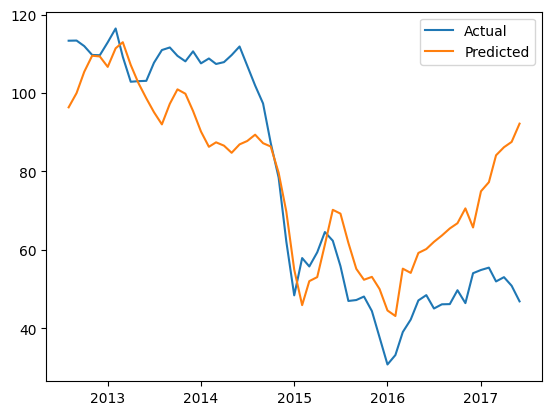

In [ ]:
mae = mean_absolute_error(y_test, y_pred_inverse_df)
print('Linear Regression Test MAE: %.3f' % mae)
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred_inverse_df, label = 'Predicted')
plt.legend()
plt.show()

#### Linear Regression (not scaled)

In [74]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Linear Regression Test MAE: %.3f' % mae)

Linear Regression Test MAE: 13.473


For learning purposes, note that there is no difference in MAE between the scaled and non-scaled linear regression model. If we were to use a regularised linear regression model (LASSO, RIDGE, etc.), then the lack of scaling may introduced biases.

### Random Forest

In [33]:
rf_model = RandomForestRegressor(n_estimators=175, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

Random Forest Test MAE: 11.440


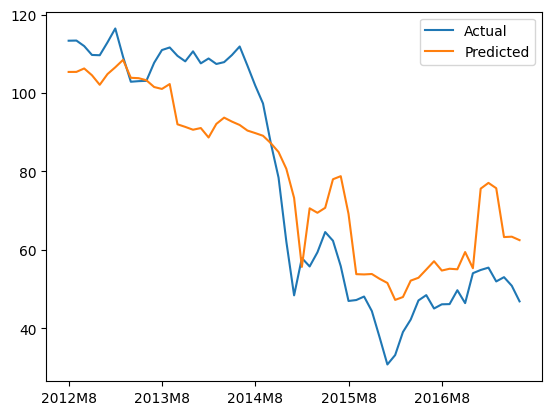

In [34]:
print('Random Forest Test MAE: %.3f' % mae)
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.xticks(np.arange(0, 60, 12))  # Set ticks every 12 months
plt.legend()
plt.show()

### ARIMA

In [35]:
from pandas import to_datetime

# Convert y_train index to datetime
y_train_idx = y_train.index

# Convert 'YYYYM' format to 'YYYY-MM' by replacing 'M' with '-'
datetime_strings = [item.replace('M', '-') for item in y_train_idx]
datetime_objects = to_datetime(datetime_strings, format="%Y-%m")

y_train.index = datetime_objects

In [36]:
# Convert y_test index to datetime
y_test_idx = y_test.index

# Convert 'YYYYM' format to 'YYYY-MM' by replacing 'M' with '-'
datetime_strings = [item.replace('M', '-') for item in y_test_idx]
datetime_objects = to_datetime(datetime_strings, format="%Y-%m")

y_test.index = datetime_objects

In [37]:
arima_model = ARIMA(y_train, order=(3,0,0), freq='MS')
arima_model_fit = arima_model.fit()
y_pred = arima_model_fit.forecast(len(y_test))
mae = mean_absolute_error(y_test, y_pred)

/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Test MAE: 17.985


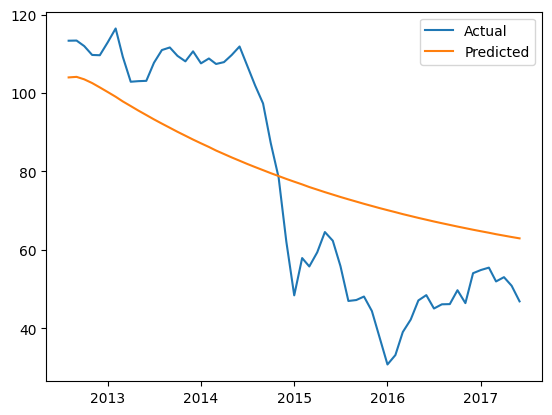

In [38]:
print('ARIMA Test MAE: %.3f' % mae)
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.legend()
plt.show()

### SARIMA

In [39]:
sarima_model = SARIMAX(y_train, 
                order=(3, 0, 2),
                seasonal_order=(0, 1, 2, 12),  # seasonal AR, seasonal differencing, seasonal MA, period
                enforce_stationarity=False,    # Allow non-stationarity
                enforce_invertibility=False)   # Allow non-invertibility
sarima_model_fit = sarima_model.fit()
y_pred = sarima_model_fit.forecast(len(y_test))
mae = mean_absolute_error(y_test, y_pred)


/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82296D+00    |proj g|=  4.60239D-01

At iterate    5    f=  2.53677D+00    |proj g|=  1.45040D-01

At iterate   10    f=  2.52833D+00    |proj g|=  3.69881D-02

At iterate   15    f=  2.51001D+00    |proj g|=  2.07178D-01

At iterate   20    f=  2.50728D+00    |proj g|=  1.66688D-02

At iterate   25    f=  2.50703D+00    |proj g|=  4.76899D-03

At iterate   30    f=  2.50696D+00    |proj g|=  3.16033D-02

At iterate   35    f=  2.50691D+00    |proj g|=  8.45205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

SARIMA Test MAE: 21.087


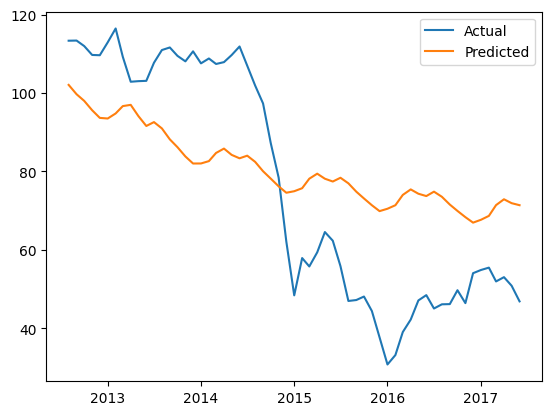

In [40]:
print('SARIMA Test MAE: %.3f' % mae)
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.legend()
plt.show()

### SARIMAX

In [41]:
# Convert X_train index to datetime
X_train_idx = X_train.index

# Convert 'YYYYM' format to 'YYYY-MM' by replacing 'M' with '-'
datetime_strings = [item.replace('M', '-') for item in X_train_idx]
datetime_objects = to_datetime(datetime_strings, format="%Y-%m")

X_train.index = datetime_objects

In [42]:
# Convert X_test index to datetime
X_test_idx = X_test.index

# Convert 'YYYYM' format to 'YYYY-MM' by replacing 'M' with '-'
datetime_strings = [item.replace('M', '-') for item in X_test_idx]
datetime_objects = to_datetime(datetime_strings, format="%Y-%m")

X_test.index = datetime_objects

In [47]:
sarimax_model = SARIMAX(y_train, 
                order=(3, 0, 0),
                seasonal_order=(0, 1, 2, 12),  # seasonal AR, seasonal differencing, seasonal MA, period
                enforce_stationarity=False,    # Allow non-stationarity
                enforce_invertibility=False,   # Allow non-invertibility
                exog=X_train_scaled)
sarimax_model_fit = sarimax_model.fit(maxiter=75)
y_pred = sarimax_model_fit.forecast(len(y_test), exog=X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)

/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           59     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29595D+00    |proj g|=  1.33765D-01


 This problem is unconstrained.



At iterate    5    f=  2.26624D+00    |proj g|=  1.62328D-02

At iterate   10    f=  2.25581D+00    |proj g|=  2.47529D-02

At iterate   15    f=  2.22510D+00    |proj g|=  2.72761D-02

At iterate   20    f=  2.21714D+00    |proj g|=  1.84573D-02

At iterate   25    f=  2.21263D+00    |proj g|=  8.04130D-03

At iterate   30    f=  2.20777D+00    |proj g|=  3.04731D-02

At iterate   35    f=  2.20242D+00    |proj g|=  1.38241D-02

At iterate   40    f=  2.19911D+00    |proj g|=  1.66992D-02

At iterate   45    f=  2.19560D+00    |proj g|=  5.34831D-03

At iterate   50    f=  2.19422D+00    |proj g|=  1.06185D-02

At iterate   55    f=  2.19126D+00    |proj g|=  1.96650D-02

At iterate   60    f=  2.18967D+00    |proj g|=  1.62130D-02

At iterate   65    f=  2.18639D+00    |proj g|=  1.22675D-02

At iterate   70    f=  2.18116D+00    |proj g|=  1.83041D-02


/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   75    f=  2.17872D+00    |proj g|=  1.36864D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   59     75     82      1     0     0   1.369D-02   2.179D+00
  F =   2.1787226309755208     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


SARIMAX Test MAE: 12.024


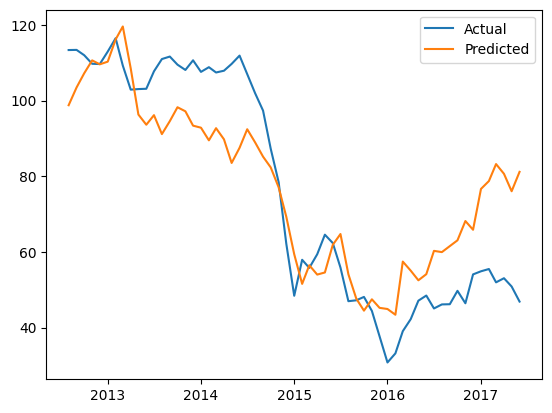

In [48]:
print('SARIMAX Test MAE: %.3f' % mae)
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.legend()
plt.show()

#### SARIMAX (exog not scaled)

In [79]:
sarimax_model = SARIMAX(y_train, 
                order=(3, 0, 0),
                seasonal_order=(0, 1, 2, 12),  # seasonal AR, seasonal differencing, seasonal MA, period
                enforce_stationarity=False,    # Allow non-stationarity
                enforce_invertibility=False,   # Allow non-invertibility
                exog=X_train)
sarimax_model_fit = sarimax_model.fit(maxiter=75)
y_pred = sarimax_model_fit.forecast(len(y_test), exog=X_test)
mae = mean_absolute_error(y_test, y_pred)
print('SARIMAX Test MAE: %.3f' % mae)

/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           59     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29595D+00    |proj g|=  2.68716D+02

At iterate    5    f=  2.28656D+00    |proj g|=  1.38683D+01

At iterate   10    f=  2.27134D+00    |proj g|=  4.54692D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/xaviersan/.pyenv/versions/brent/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   59     13     55      2     0     0   1.101D+01   2.268D+00
  F =   2.2678025346901589     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMAX Test MAE: 12.083


In this case, the lack of scaling lead to convergence failure of the Maximum Likelihood Estimators. This is possibly due to scaling issues. We also notice minor better performance of the scaled model.

### Summary

We observe that the MAEs of the ML models in this notebook (~11-13) are much higher than the LSTM model's MAE of ~ 3. This showcases the LSTM model's proficiency in handling long-term dependencies and non-linear relationships.

The next steps could be to do the following:
1. Experiment with more advanced LSTM Architecture (e.g. LSTM with attention mechanism)
2. Combine LSTM with other models to capture both short-term linear trends and non-linear long-term dependencies effectively (e.g. Model short-term patterns with other ML model, then pass the residuals to the LSTM model to learn the non-linear long-term dependencies)
3. Explore relationships between POILBRE and other variables, reduce dimensions or feature engineer to improve accuracy